# Test Notebook Graph

In [1]:
import pandas as pd
from py2neo import Graph
import matplotlib.pyplot as plt
import numpy as np

# host + port
host = 'http://localhost:7474'

# select database name
db_name = 'modelparallel'

# credentials for API
user = 'neo4j'
passwd = '1234'

# connect to database
call_graph = Graph(host, auth=(user, passwd), name=db_name)

## Test functions here

   funktionelle_Gruppe  Anzahl_HTI_Kanten_0  share_hti_0  Anzahl_HTI_Kanten_1  \
0              -H2 -O1                  460     5.476190                  457   
1                  -C1                  595     7.083333                  472   
2              -C1 -H2                  593     7.059524                  496   
3              -C1 -O1                  590     7.023810                  552   
4          -C2 -H4 -O1                  512     6.095238                  512   
5               -H2 O1                  560     6.666667                  434   
6                   O2                  490     5.833333                  325   
7              -C1 -O2                  471     5.607143                  540   
8           -C1 -H2 O1                  545     6.488095                  398   
9                   O1                  586     6.976190                  438   
10                 -H2                  566     6.738095                  480   
11         -C4 -H4 -O1      

C:\Users\philipp\AppData\Local\Temp/ipykernel_16420/274946954.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

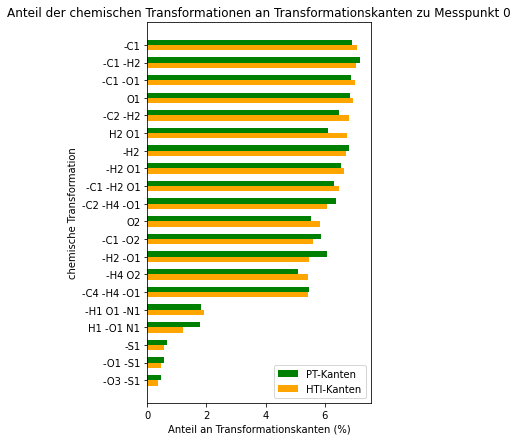

<Figure size 432x288 with 0 Axes>

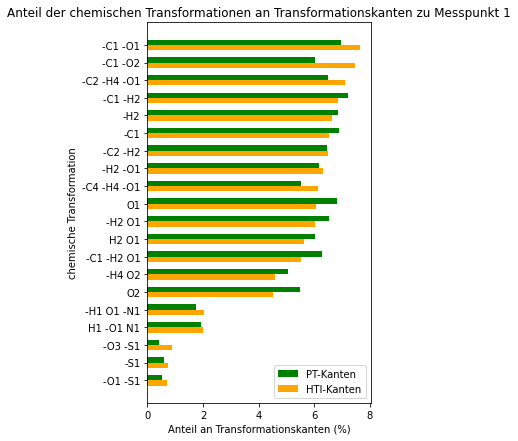

<Figure size 432x288 with 0 Axes>

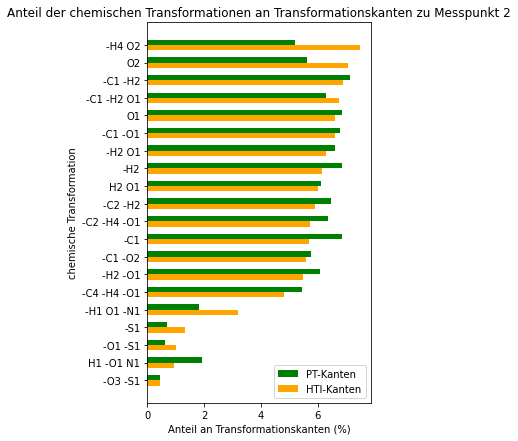

<Figure size 432x288 with 0 Axes>

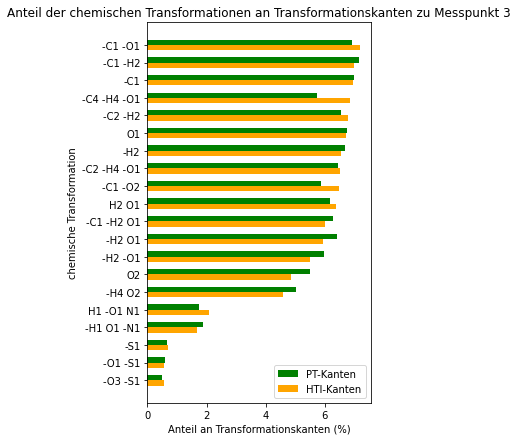

<Figure size 432x288 with 0 Axes>

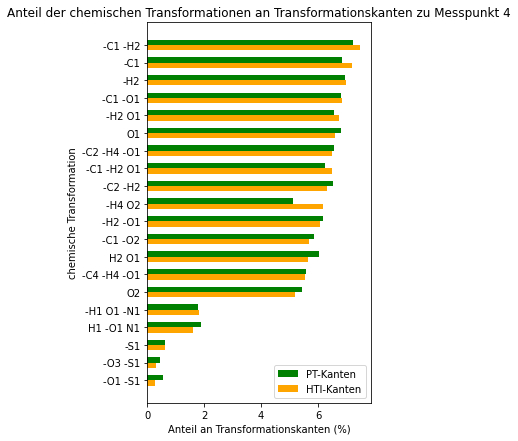

<Figure size 432x288 with 0 Axes>

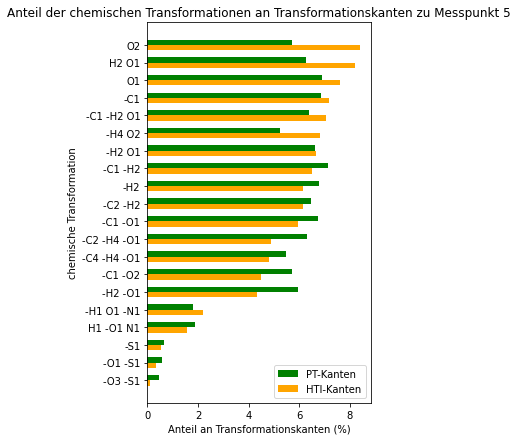

<Figure size 432x288 with 0 Axes>

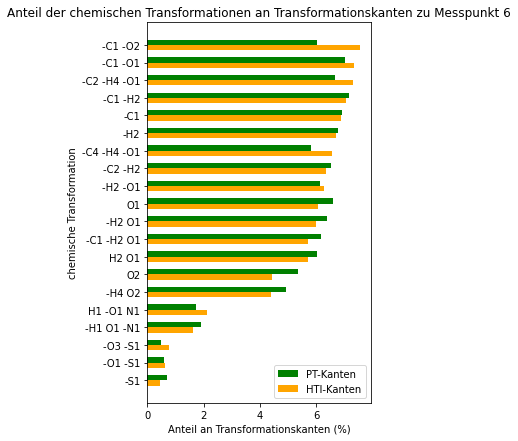

<Figure size 432x288 with 0 Axes>

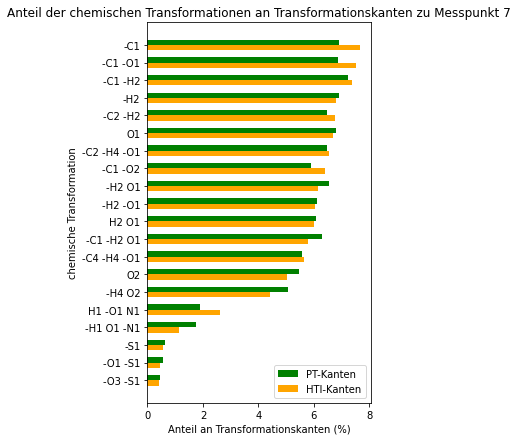

<Figure size 432x288 with 0 Axes>

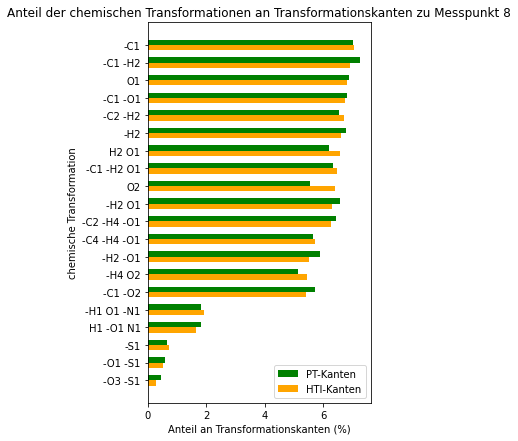

<Figure size 432x288 with 0 Axes>

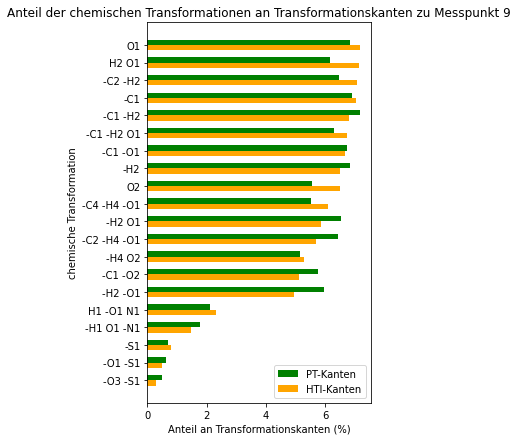

<Figure size 432x288 with 0 Axes>

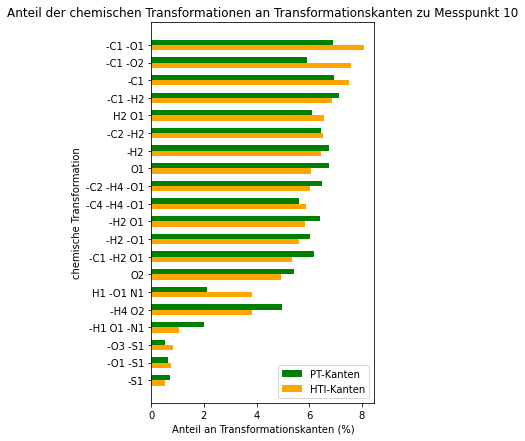

<Figure size 432x288 with 0 Axes>

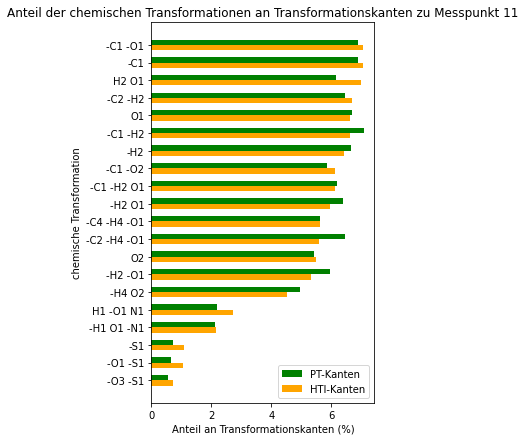

In [60]:
df_time = call_graph.run("""
    MATCH (t:Measurement)
    RETURN t.point_in_time as time
""").to_data_frame()

time_list = df_time['time'].to_list()
del time_list[-1]

df_tu_hti = call_graph.run("""
    MATCH (:Molecule)-[t:HAS_TRANSFORMED_INTO]->(:Molecule)
    RETURN DISTINCT t.transformation_unit as funktionelle_Gruppe
    """).to_data_frame()

df_tu_pt = call_graph.run("""
    MATCH (:Molecule)-[t:POTENTIAL_TRANSFORMATION]->(:Molecule)
    RETURN DISTINCT t.tu_pt as funktionelle_Gruppe
    """).to_data_frame()

for ele in time_list:
    transform_count_hti = call_graph.run("""
    MATCH (m:Measurement)-[:MEASURED_IN]-(:Molecule)-[t:HAS_TRANSFORMED_INTO]->(:Molecule)
    WHERE m.point_in_time = """ + str(ele) + """
    RETURN t.transformation_unit as funktionelle_Gruppe, count(t.transformation_unit) as Anzahl_HTI_Kanten_""" + str(ele) + """
    ORDER BY Anzahl_HTI_Kanten_""" + str(ele) + """ DESC
    """).to_data_frame()

    transform_count_cti = call_graph.run("""
    MATCH (m:Measurement)-[:MEASURED_IN]-(:Molecule)-[t:POTENTIAL_TRANSFORMATION]->(:Molecule)
    WHERE m.point_in_time = """ + str(ele) + """
    RETURN t.tu_pt as funktionelle_Gruppe, count(t.tu_pt) as Anzahl_CTI_Kanten_""" + str(ele) + """
    ORDER BY Anzahl_CTI_Kanten_""" + str(ele) + """ DESC
    """).to_data_frame()
    
    df_tu_hti = pd.merge(df_tu_hti, transform_count_hti, on=["funktionelle_Gruppe"])
    df_tu_hti['share_hti_' + str(ele)] = df_tu_hti['Anzahl_HTI_Kanten_' + str(ele)]/df_tu_hti['Anzahl_HTI_Kanten_' + str(ele)].sum()*100
    
    df_tu_pt = pd.merge(df_tu_pt, transform_count_cti, on=["funktionelle_Gruppe"])
    df_tu_pt['share_cti_' + str(ele)] = df_tu_pt['Anzahl_CTI_Kanten_' + str(ele)]/df_tu_pt['Anzahl_CTI_Kanten_' + str(ele)].sum()*100

df_join = pd.merge(df_tu_hti, df_tu_pt, on=["funktionelle_Gruppe"])

print(df_join)

for ele in time_list:
    element = 'share_hti_' + str(ele)
    df_join = df_join.sort_values([element])
    
    plt.figure()
    labels = df_join['funktionelle_Gruppe'].to_list()
    x = np.arange(len(labels))
    height = 0.3
    plt.figure(figsize=(4, 7))
    plt.barh(x + height/2, df_join['share_cti_' + str(ele)], height = 0.3, color='green')
    plt.barh(x - height/2 , df_join['share_hti_' + str(ele)], height = 0.3, color='orange')
    plt.yticks(x, labels = labels)
    plt.title('Anteil der chemischen Transformationen an Transformationskanten zu Messpunkt ' + str(ele))
    plt.ylabel('chemische Transformation')
    plt.xlabel('Anteil an Transformationskanten (%)')
    plt.legend(['PT-Kanten', 'HTI-Kanten'])

plt.show()
plt.close()

In [62]:
df_time = call_graph.run("""
    MATCH (t:Measurement)
    RETURN t.point_in_time as time
""").to_data_frame()

time_list = df_time['time'].to_list()
del time_list[-1]

df_tu_hti = call_graph.run("""
    MATCH (:Molecule)-[t:HAS_TRANSFORMED_INTO]->(:Molecule)
    RETURN DISTINCT t.transformation_unit as funktionelle_Gruppe
    """).to_data_frame()

df_tu_pt = call_graph.run("""
    MATCH (:Molecule)-[t:POTENTIAL_TRANSFORMATION]->(:Molecule)
    RETURN DISTINCT t.tu_pt as funktionelle_Gruppe
    """).to_data_frame()

for ele in time_list:
    transform_count_hti = call_graph.run("""
    MATCH (m:Measurement)-[:MEASURED_IN]-(:Molecule)-[t:HAS_TRANSFORMED_INTO]->(:Molecule)
    WHERE m.point_in_time = """ + str(ele) + """
    RETURN t.transformation_unit as funktionelle_Gruppe, count(t.transformation_unit) as Anzahl_HTI_Kanten_""" + str(ele) + """
    ORDER BY Anzahl_HTI_Kanten_""" + str(ele) + """ DESC
    """).to_data_frame()

    transform_count_cti = call_graph.run("""
    MATCH (m:Measurement)-[:MEASURED_IN]-(:Molecule)-[t:POTENTIAL_TRANSFORMATION]->(:Molecule)
    WHERE m.point_in_time = """ + str(ele) + """
    RETURN t.tu_pt as funktionelle_Gruppe, count(t.tu_pt) as Anzahl_CTI_Kanten_""" + str(ele) + """
    ORDER BY Anzahl_CTI_Kanten_""" + str(ele) + """ DESC
    """).to_data_frame()
    
    df_tu_hti = pd.merge(df_tu_hti, transform_count_hti, on=["funktionelle_Gruppe"])
    df_tu_hti['share_hti_' + str(ele)] = df_tu_hti['Anzahl_HTI_Kanten_' + str(ele)]/df_tu_hti['Anzahl_HTI_Kanten_' + str(ele)].sum()*100
    
    df_tu_pt = pd.merge(df_tu_pt, transform_count_cti, on=["funktionelle_Gruppe"])
    df_tu_pt['share_cti_' + str(ele)] = df_tu_pt['Anzahl_CTI_Kanten_' + str(ele)]/df_tu_pt['Anzahl_CTI_Kanten_' + str(ele)].sum()*100

df_join = pd.merge(df_tu_hti, df_tu_pt, on=["funktionelle_Gruppe"])

print(df_join)

   funktionelle_Gruppe  Anzahl_HTI_Kanten_0  share_hti_0  Anzahl_HTI_Kanten_1  \
0              -H2 -O1                  460     5.476190                  457   
1                  -C1                  595     7.083333                  472   
2              -C1 -H2                  593     7.059524                  496   
3              -C1 -O1                  590     7.023810                  552   
4          -C2 -H4 -O1                  512     6.095238                  512   
5               -H2 O1                  560     6.666667                  434   
6                   O2                  490     5.833333                  325   
7              -C1 -O2                  471     5.607143                  540   
8           -C1 -H2 O1                  545     6.488095                  398   
9                   O1                  586     6.976190                  438   
10                 -H2                  566     6.738095                  480   
11         -C4 -H4 -O1      

-H2 -O1


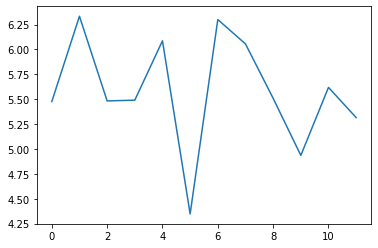

In [68]:
time_list = [0,1,2,3,4,5,6,7,8,9,10,11]
y_list = []
for ele in time_list:
    y_list.append(df_join['share_hti_' + str(ele)][0])
    
print(df_join['funktionelle_Gruppe'][0])
    
plt.plot(time_list, y_list)